## Taking the modelling approach - Start with row wise like XGB and then move on to sequneital model like LSTM !

What do we know :

1. Masked data : deal with it (EDA)
2. Hghly imbalanced data 
3. Acc id and weekly start date - take one instance togehter
4. Sampling needs to be done on ACCOUNTS and split the test train

Process:
1. Gather sense of whats going on in data ( Deal with masked data - EDA and feature engineering)
2. Preprocess and split
3. Undersample or over sample (Correlation , anaomaly detection, Dimensionality reduction)
4. Testing (LR or NN)
   



In [1]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold,StratifiedKFold
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from pylab import rcParams
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [17]:
df_train = pd.read_csv("Train_Set.csv")
print(df_train.head())
print(df_train.shape)
df_test = pd.read_csv('Test_Set.csv')
print(df_test.shape)

   account_id week_start_date  feature1  feature2   feature3  feature4  \
0    100559.0      2018-09-03       0.0       0.0   0.000000       0.0   
1    101026.0      2018-09-03       0.0       0.0   0.000000       0.0   
2    101026.0      2018-09-10       0.0       0.0  86.666667       0.0   
3    101026.0      2018-09-17       0.0       0.0  -0.076046       0.0   
4    101026.0      2018-09-24       0.0       0.0  -0.987654       0.0   

   feature5  feature6  feature7  feature8  ...  feature54  feature55  \
0       0.0       0.0       0.0       0.0  ...        0.0   0.000000   
1       0.0       0.0       0.0       0.0  ...        0.0   0.000000   
2       0.0       0.0       0.0       0.0  ...        0.0   0.333333   
3       0.0       0.0       0.0       0.0  ...        0.0   0.000000   
4       0.0       0.0       0.0       0.0  ...        0.0   0.000000   

   feature56  feature57  feature58  feature59  feature60  feature61  \
0        0.0        0.0        0.0        0.0      

In [3]:
# df_train.info()
#No Null values
df_train.isnull().sum().max()

0

In [ ]:
# see the time spent by each account 
df_train['week_start_date'] =  pd.to_datetime(df_train['week_start_date'])

df_train = df_train.sort_values(['account_id', 'week_start_date'])
df_train['Time in Status'] = df_train.groupby('account_id')['week_start_date'].diff()
df_train['Time in Status'].value_counts()

In [4]:
columns =[c for c in df_train.columns if 'feature' in c]
print("No of features {}".format(len(columns)))

print("The type of features:")
print(df_train[columns].dtypes.value_counts())

No of features 62
The type of features:
float64    62
dtype: int64


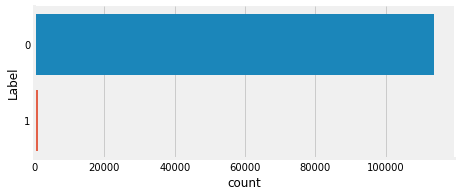

In [5]:
# Distribution of Target variable
ax = sns.catplot(y="Label", kind="count", data=df_train, height=2.6, aspect=2.5, orient='h')

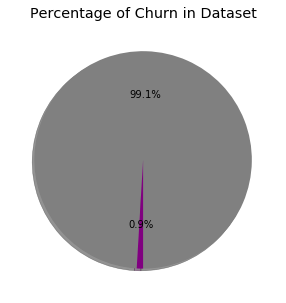

0    113630
1      1076
Name: Label, dtype: int64


In [6]:
#Check what percentage of customers were churned/when do we intervene
sizes = df_train['Label'].value_counts(sort = True)
colors = ["grey","purple"] 
rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes, explode=None, labels=None, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percentage of Churn in Dataset')
plt.show()
print(sizes)

In [7]:
print ("Rows     : " ,df_train.shape[0])
print ("Columns  : " ,df_train.shape[1])
print ("\nMissing values :  ", df_train.isnull().sum().values.sum())
print ("\nUnique values :  \n",df_train.nunique())

Rows     :  114706
Columns  :  65

Missing values :   0

Unique values :  
 account_id          2690
week_start_date       83
feature1             912
feature2              93
feature3           20425
                   ...  
feature59            453
feature60            513
feature61            198
feature62           2214
Label                  2
Length: 65, dtype: int64


In [8]:
#BInary features and Constant features
counts = [[], [], []]
for c in columns:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
# print('Categorical features:', counts[2])

Constant features: 0 Binary features: 0 Categorical features: 62

Constant features: []


In [ ]:
#Univariate analysis for features 
plt.rcParams['figure.figsize'] = 8, 2
for i in counts[2]:   #counts[2] has all the categorical features
    if i not in 'Label':
        plt.figure()
        plt.xlabel=i
        sns.stripplot(x=i, y="Label", data=df_train,jitter=True, linewidth=1,order=np.sort(df_train[i].unique()))
        sns.boxplot(x=i, y="Label", data=df_train, order=np.sort(df_train[i].unique()))
        plt.show()

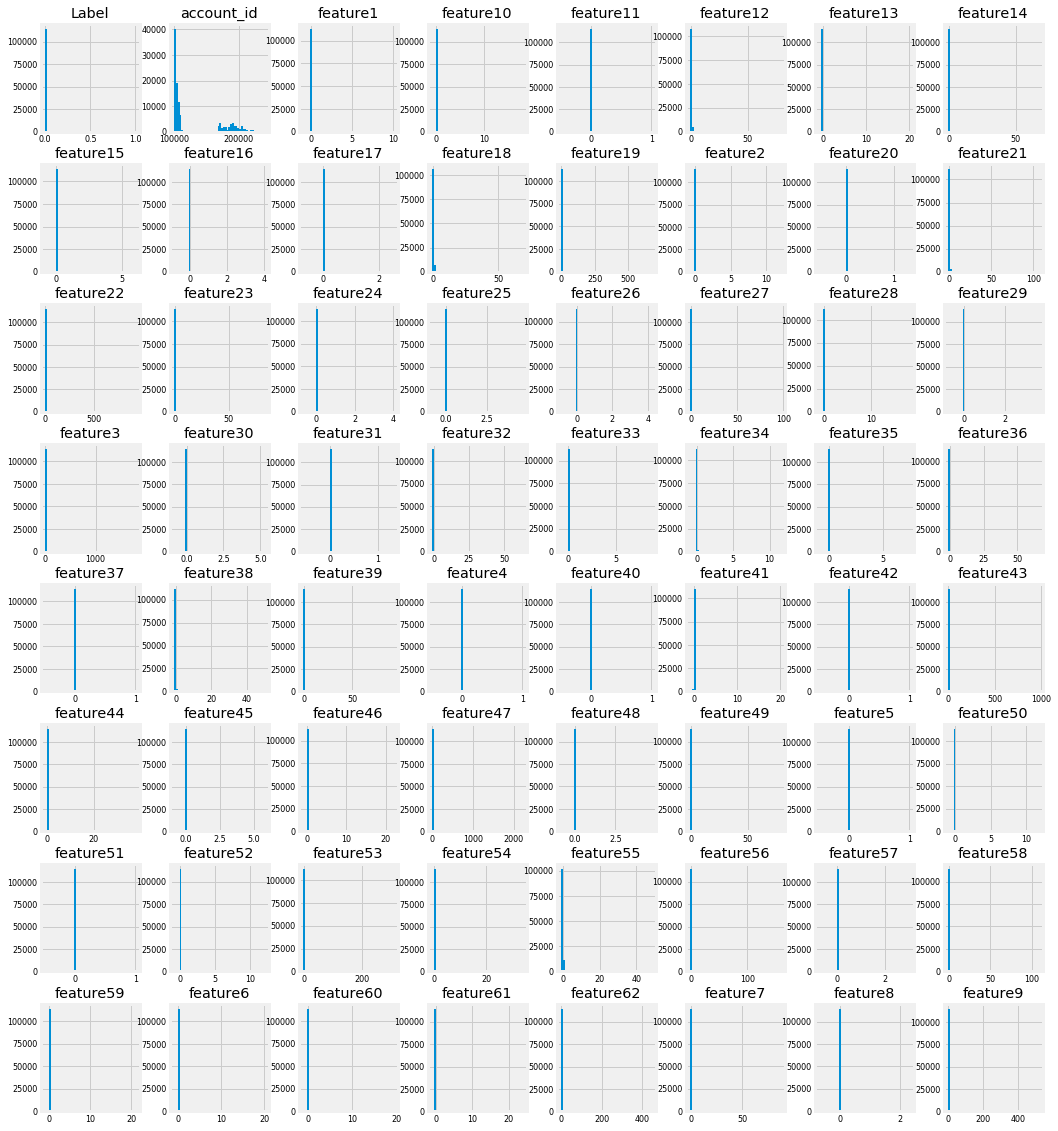

In [9]:
#Univariate 
df_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [10]:
# Strong correlation (if any)
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['Label'][:-1] # -1 because the latest row is Label
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Label:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with Label:
Series([], Name: Label, dtype: float64)


In [ ]:
#Bi variate analysis
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i+1:i+4],
                y_vars=['Label'])

In [12]:
# Features with very low variance
count = 0
low_var_col=[]
for i in counts[2]:
    if df_train[i].var()<0.01:
        low_var_col.append(i)
        count+=1
print(count)

29


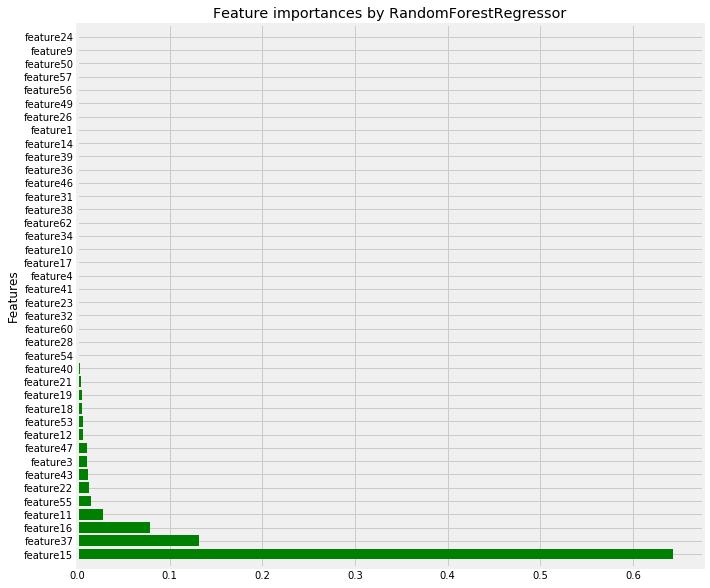

In [13]:

train_y = df_train['Label']
df_train.drop(['Label'],axis=1,inplace=True)
df_train.drop(['account_id','week_start_date'],axis=1,inplace=True)

train_X = df_train

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)
feature_names = train_X.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:40]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

In [ ]:
df_train=df_train.set_index(['account_id','week_start_date'])

In [30]:
# Model right of the bat, no feature selection/Engineering

# Remove 'id' and 'target' columns
labels = df_train.columns[2:65]
# df_train.head()
X = df_train[labels]
y = df_train['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [19]:
model = XGBClassifier()
model.fit(X_train[['feature1']], y_train)
y_pred = model.predict(X_test[['feature1']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.09%


In [21]:
target_count =df_train.Label.value_counts()
print(target_count[0],target_count[1])

113630 1076


Confusion matrix:
 [[22733     0]
 [  209     0]]


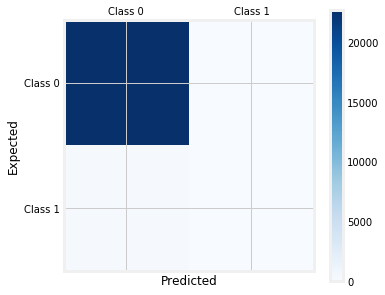

In [22]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

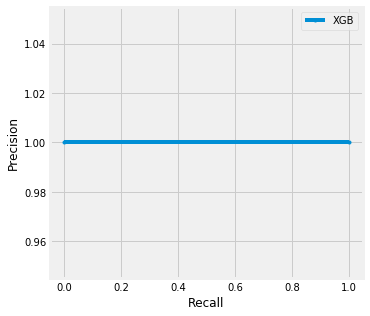

In [32]:
from sklearn.metrics import precision_recall_curve
# X=X.values
# y=y.values
# model.fit(X_train,y_train)
probx=model.predict_proba(X_test)
# probx
p,r,_=precision_recall_curve(y_test,probx[:,1])
plt.plot(r, p, marker='.', label='XGB')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


In [33]:
# Class count
count_class_0, count_class_1 = df.Label.value_counts()

# Divide by class
df_class_0 = df[df['Label'] == 0]
df_class_1 = df[df['Label'] == 1]

NameError: name 'df' is not defined

In [34]:
#Under Sampling 
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Label.value_counts())

df_test_under.Label.value_counts().plot(kind='bar', title='Count (target)');

NameError: name 'df_class_0' is not defined

In [ ]:
df_test_under.describe()

In [ ]:
#Feature Importance 
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
# One-hot encode
# df = pd.get_dummies(df)
# Drop redundant columns (for features with two unique values)
# drop = ['Churn_Yes', 'Churn_No', 'gender_Female', 'Partner_No',
#         'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No']
x, y = df.loc[:,df.columns !='Label'], df['Label']
# Fit RandomForest Classifier
# df=df.drop(['account_id','week_start_date'],axis=1)
clf = RandomForestClassifier(**params)
clf = clf.fit(x,y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

 ## Splitting and Preprocessing 
 
 #### Before proceeding with the Random UnderSampling technique we have to separate the orginal dataframe. Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Churn', round(df_train['Label'].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('Churn', round(df_train['Label'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

X = df_train.drop('Label', axis=1)
X=df_train.drop('week_start_date',axis=1)
# X=df_train.drop('Time')
y = df_train['Label']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    
# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Churn 99.06 % of the dataset
Churn 0.94 % of the dataset
Train: [ 10018  10019  10077 ... 114703 114704 114705] Test: [    0     1     2 ... 23216 23217 23218]
Train: [     0      1      2 ... 114703 114704 114705] Test: [10018 10019 10077 ... 46435 46436 46437]
Train: [     0      1      2 ... 114703 114704 114705] Test: [20397 20451 20453 ... 69251 69252 69253]
Train: [     0      1      2 ... 114703 114704 114705] Test: [30093 30172 30174 ... 91977 91978 91979]
Train: [    0     1     2 ... 91977 91978 91979] Test: [ 40308  40414  40416 ... 114703 114704 114705]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99061734 0.00938266]
[0.99062813 0.00937187]


In [36]:
new_df = df_train.groupby('account_id').apply(lambda x: x.sample(frac=1)).reset_index(drop = True)


# amount of churn classes 1076 rows.
churn_df = new_df.loc[new_df['Label'] == 1]
non_churn_df = new_df.loc[new_df['Label'] == 0][:1076]
print(len(churn_df),len(non_churn_df))
normal_distributed_df = pd.concat([churn_df, non_churn_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)



1076 1076


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Label, dtype: float64


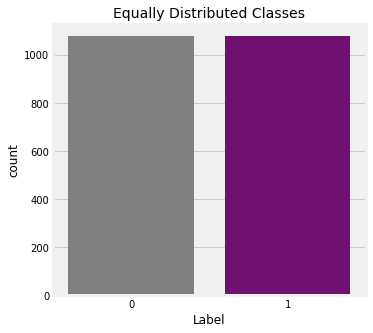

In [37]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Label'].value_counts()/len(new_df))



sns.countplot('Label', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

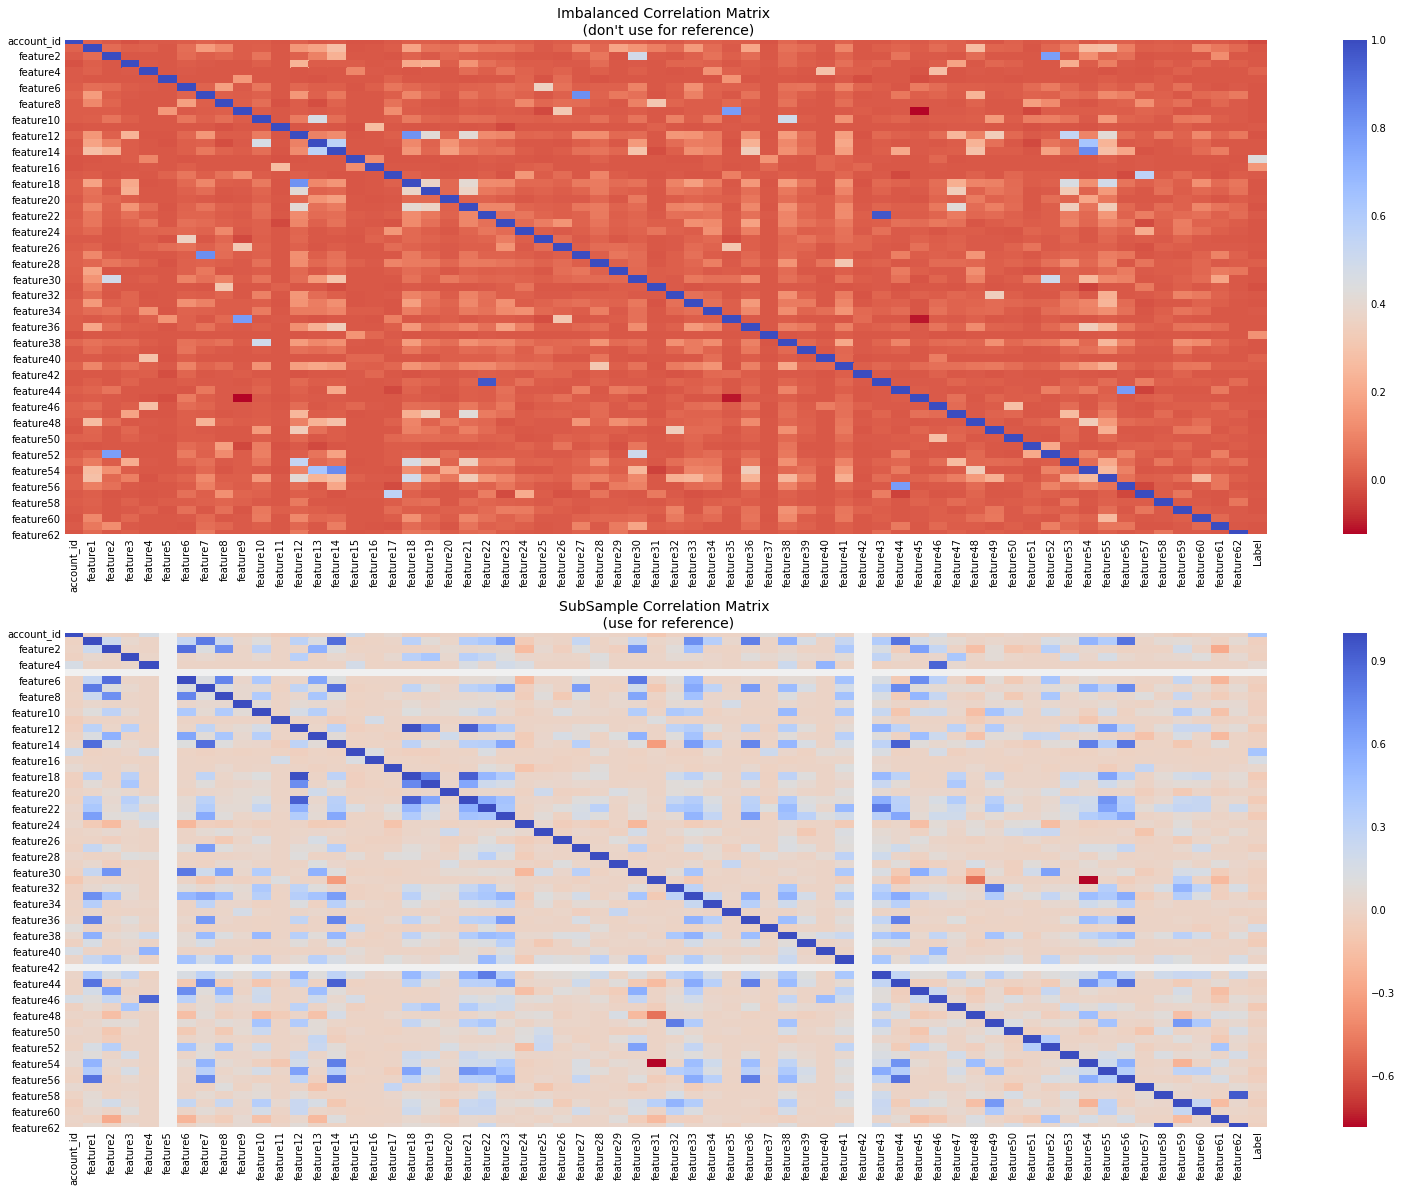

In [38]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df_train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [39]:
# Dimensionality reduction 

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Label', axis=1)
X=  new_df.drop('week_start_date',axis=1)
y = new_df['Label']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))



T-SNE took 1.8e+01 s
PCA took 0.023 s


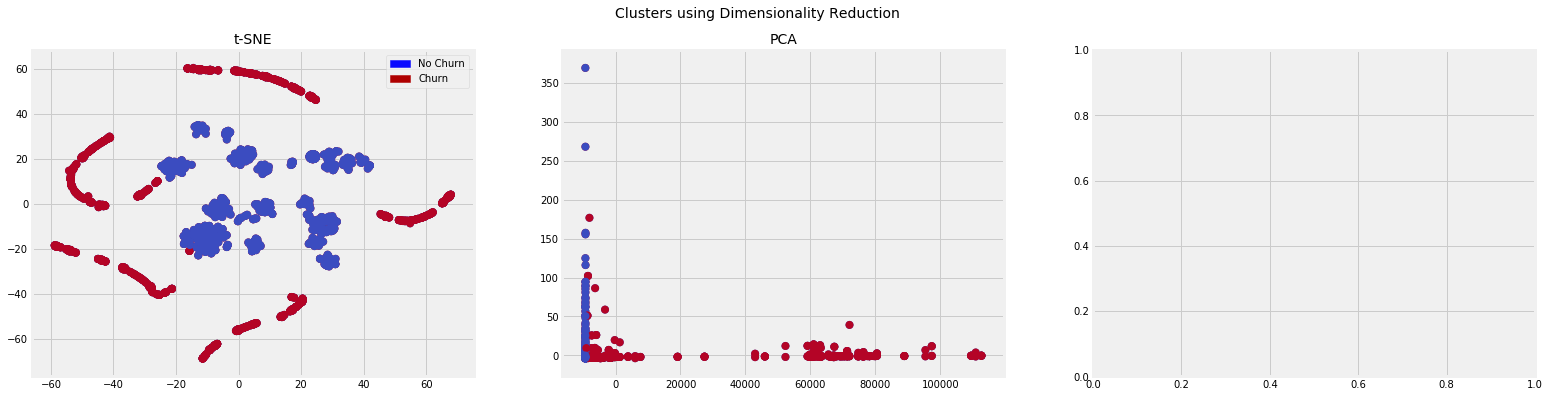

In [40]:
f, (ax1, ax2,_) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Churn', 'Churn']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Churn')
red_patch = mpatches.Patch(color='#AF0000', label='Churn')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax1.legend(handles=[blue_patch, red_patch])



In [41]:
# Undersampling before Cross validating( Wrong way - high variance)

from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [43]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 50.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 100.0 % accuracy score
Classifiers:  SVC Has a training score of 79.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score


In [44]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [45]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  50.2%
Knears Neighbors Cross Validation Score 100.0%
Support Vector Classifier Cross Validation Score 99.77%
DecisionTree Classifier Cross Validation Score 100.0%


In [46]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

## Correct approach !


In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression(C=1, penalty='l1', solver='liblinear')




rand_log_reg = RandomizedSearchCV(LogisticRegression(C=1, penalty='l1', solver='liblinear'), log_reg_params, n_iter=4)

# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 91765 | Length of y (train): 91765
Length of X (test): 22941 | Length of y (test): 22941
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


In [48]:
labels = ['No Churn', 'Churn']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00     22726
       Churn       1.00      1.00      1.00       215

    accuracy                           1.00     22941
   macro avg       1.00      1.00      1.00     22941
weighted avg       1.00      1.00      1.00     22941



NameError: name 'average_precision' is not defined

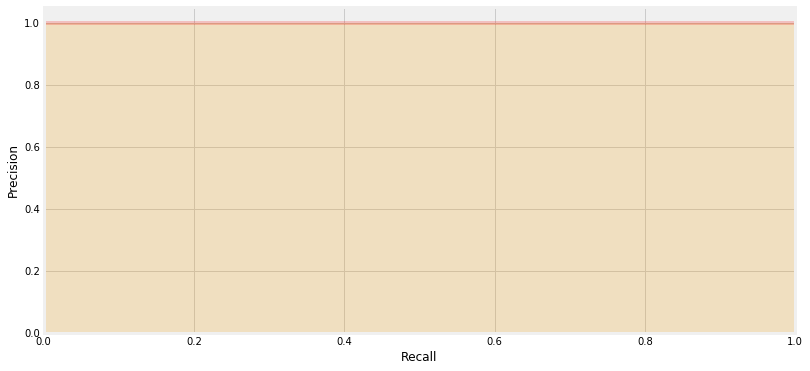

In [49]:
from sklearn.metrics import precision_recall_curve


y_score = best_est.decision_function(original_Xtest)
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='#F59B00')

plt.xlabel("Recall")
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)